In [13]:
import os
import zipfile
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import torch.nn.functional as F
from google.colab import drive
import zipfile

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+------------+--------------+------------------------+
| Data Split | Total Images |      Image Shape       |
+------------+--------------+------------------------+
|  Training  |     9664     | torch.Size([128, 128]) |
|  Testing   |     544      | torch.Size([128, 128]) |
| Validation |     1120     | torch.Size([128, 128]) |
+------------+--------------+------------------------+


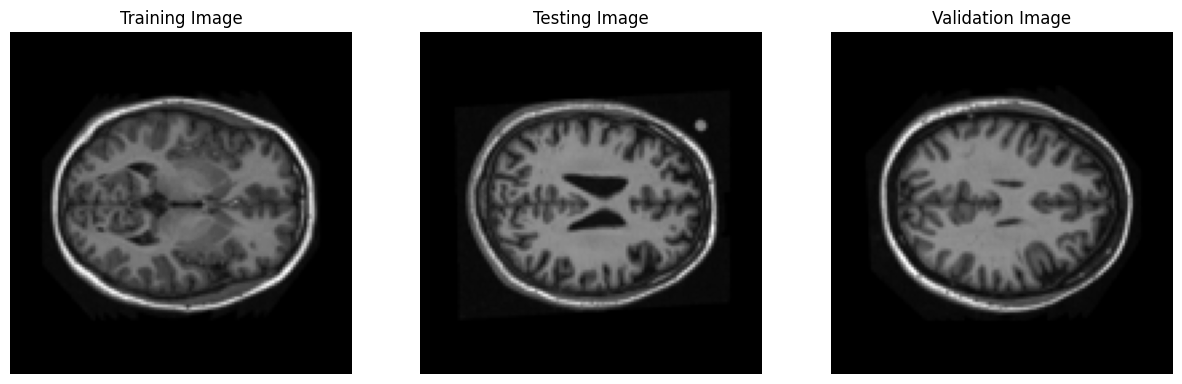

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

In [14]:
# Ensure that PyTorch uses the GPU (if available) or CPU otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mounting Google Drive to access files. Note: This is specific to Google Colab.
drive.mount('/content/drive')

# Define the directory where the output will be saved
OUTPUT_DIR = "/content/drive/MyDrive/Colab_Notebooks_Course/image_process/A3/OUTPUT2"

# Create the directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Dataset class to handle brain slice images
class BrainSlicesDataset(Dataset):
    def __init__(self, image_slices):
        self.image_slices = image_slices

    def __len__(self):
        # Return the total number of image slices
        return len(self.image_slices)

    def __getitem__(self, idx):
        image = self.image_slices[idx]

        # Ensure the image has a channel dimension (grayscale images may not have one)
        if len(image.shape) == 2:  # If the image is of shape [Height, Width]
            image = torch.unsqueeze(image, 0)  # Convert it to [1, Height, Width]

        return image


def get_image_slices():
    zip_path = "/content/drive/MyDrive/Colab_Notebooks_Course/image_process/A3/testgans/GAN_Dataset.zip"
    extraction_path = "/content/GAN_Dataset"
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)

    parent_dir = "/content/GAN_Dataset"
    train_path = os.path.join(parent_dir, "keras_png_slices_train")
    test_path = os.path.join(parent_dir, "keras_png_slices_test")
    val_path = os.path.join(parent_dir, "keras_png_slices_validate")

    def load_images_from_folder(folder_path):
            images = []
            for filename in os.listdir(folder_path):
                img = Image.open(os.path.join(folder_path, filename)).convert('L').resize((128, 128))
                if img is not None:
                    images.append(torch.tensor(np.array(img, dtype=np.float32)))
            return torch.stack(images)

    train_images = load_images_from_folder(train_path)
    test_images = load_images_from_folder(test_path)
    validate_images = load_images_from_folder(val_path)

    return train_images, test_images, validate_images

def get_image_slices_with_table():
    train_images, test_images, validate_images = get_image_slices()

    # Create table to display data summary
    table = PrettyTable()
    table.field_names = ["Data Split", "Total Images", "Image Shape"]
    table.add_row(["Training", len(train_images), train_images[0].shape])
    table.add_row(["Testing", len(test_images), test_images[0].shape])
    table.add_row(["Validation", len(validate_images), validate_images[0].shape])

    print(table)

    # Plot one image from each set
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(train_images[0], cmap='gray')
    axs[0].set_title("Training Image")
    axs[0].axis('off')

    axs[1].imshow(test_images[0], cmap='gray')
    axs[1].set_title("Testing Image")
    axs[1].axis('off')

    axs[2].imshow(validate_images[0], cmap='gray')
    axs[2].set_title("Validation Image")
    axs[2].axis('off')

    plt.show()

    return train_images, test_images, validate_images

# Call the function to see the table
get_image_slices_with_table()

In [15]:
# Model Definitions: VectorQuantizer, Encoder, Decoder, VQVAE, PixelCNN, etc.

# VectorQuantizer Layer
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = beta
        self.embeddings = nn.Parameter(torch.randn(embedding_dim, num_embeddings))

    def forward(self, x):
        # Calculate distances and indices
        z_e_x = x.permute(0, 2, 3, 1).contiguous()
        z_e_x_ = z_e_x.view(-1, self.embedding_dim)
        distances = (torch.sum(z_e_x_**2, dim=1, keepdim=True)
                    + torch.sum(self.embeddings**2, dim=0)
                    - 2 * torch.matmul(z_e_x_, self.embeddings))
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings).to(x.device)
        encodings.scatter_(1, encoding_indices, 1)
        encoding_indices = encoding_indices.view(*z_e_x.shape[:-1])
        quantized = torch.matmul(encodings, self.embeddings.t()).view(*z_e_x.shape)
        # Compute loss
        e_latent_loss = F.mse_loss(quantized.detach(), z_e_x)
        q_latent_loss = F.mse_loss(quantized, z_e_x.detach())
        loss = q_latent_loss + self.beta * e_latent_loss
        quantized = z_e_x + (quantized - z_e_x).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encoding_indices

# Encoder
class Encoder(nn.Module):
    def __init__(self, input_channels, hidden_channels, embedding_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels // 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels // 2, embedding_dim, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.encoder(x)
# Decoder
class Decoder(nn.Module):
    def __init__(self, input_channels, hidden_channels):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(input_channels, hidden_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_channels, hidden_channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_channels // 2, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.decoder(x)

# VQVAE
class VQVAE(nn.Module):
    def __init__(self, input_channels, hidden_channels, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(input_channels, hidden_channels, embedding_dim)
        self.quantize = VectorQuantizer(num_embeddings, embedding_dim)
        self.decoder = Decoder(embedding_dim, hidden_channels)

    def forward(self, x):
        z = self.encoder(x)
        loss, quantized, perplexity, _ = self.quantize(z)
        x_recon = self.decoder(quantized)
        return loss, x_recon, perplexity

# VQVAETrainer
class VQVAETrainer(nn.Module):
    def __init__(self, train_variance, input_channels, hidden_channels, num_embeddings, embedding_dim):
        super(VQVAETrainer, self).__init__()
        self.train_variance = train_variance
        self.vqvae = VQVAE(input_channels, hidden_channels, num_embeddings, embedding_dim)

    def forward(self, x):
        vq_loss, x_recon, perplexity = self.vqvae(x)
        recon_loss = F.mse_loss(x_recon, x) / self.train_variance
        loss = recon_loss + vq_loss
        return x_recon, perplexity, loss

# PixelConvLayer & PixelCNN
class PixelConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, mask_type, **kwargs):
        super(PixelConvLayer, self).__init__()
        self.mask_type = mask_type
        self.padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs, padding=self.padding)
        self.mask = self.conv.weight.data.clone()
        self.create_mask()
    def forward(self, x):
        self.conv.weight.data *= self.mask
        return self.conv(x)
    def create_mask(self):
        _, _, H, W = self.conv.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, H // 2, W // 2 + (self.mask_type == 'A'):] = 0
        self.mask[:, :, H // 2 + 1:] = 0

class PixelCNN(nn.Module):
    def __init__(self, input_shape, num_embeddings, embedding_dim):
        super(PixelCNN, self).__init__()
        self.input_shape = input_shape
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.layers = nn.ModuleList()
        self.layers.append(PixelConvLayer(input_shape[0], embedding_dim, 7, mask_type='A'))
        for _ in range(5):
            self.layers.append(PixelConvLayer(embedding_dim, embedding_dim, 7, mask_type='B'))
        self.layers.append(nn.Conv2d(embedding_dim, num_embeddings, 1))
    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        return x


In [16]:
def train_vqvae(vqvae, train_loader, num_epochs, learning_rate, test_samples, recon_losses, vq_losses, perplexities):
    optimizer = optim.Adam(vqvae.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for batch_idx, images in enumerate(train_loader):
            images = images.to(device)

            optimizer.zero_grad()
            x_recon, perplexity, loss = vqvae(images)

            # Record the losses and perplexity
            recon_loss_value = F.mse_loss(x_recon, images) / vqvae.train_variance
            vq_loss_value = loss - recon_loss_value
            recon_losses.append(recon_loss_value.item())
            vq_losses.append(vq_loss_value.item())
            perplexities.append(perplexity.item())

            loss.backward()
            optimizer.step()

    # Visualization at the end of each epoch
        with torch.no_grad():
            reconstructions, _, _ = vqvae(test_samples)
            visualize_reconstructions(test_samples.cpu(), reconstructions.cpu())


        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    plt.figure(figsize=(10,5))
    plt.plot(recon_losses, label='Reconstruction Loss')
    plt.plot(vq_losses, label='VQ Loss')
    plt.legend()
    plt.title('Losses over Training')
    plt.xlabel('Training Iterations')
    plt.ylabel('Loss Value')
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(perplexities)
    plt.title('Perplexity over Training')
    plt.xlabel('Training Iterations')
    plt.ylabel('Perplexity')
    plt.show()

    with torch.no_grad():
        _, _, _, encoding_indices = vqvae.vqvae.quantize(vqvae.vqvae.encoder(test_samples))
        encoding_indices = encoding_indices.flatten().cpu().numpy()

    plt.figure(figsize=(10,5))
    plt.hist(encoding_indices, bins=np.arange(vqvae.vqvae.quantize.num_embeddings+1)-0.5, rwidth=0.8)
    plt.title('Histogram of Encoding Indices')
    plt.xlabel('Encoding Index')
    plt.ylabel('Frequency')
    plt.xticks(np.arange(vqvae.vqvae.quantize.num_embeddings))
    plt.show()

def train_pixelcnn(pixelcnn, train_loader, num_epochs, learning_rate):
    optimizer = optim.Adam(pixelcnn.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        for images in train_loader:
            optimizer.zero_grad()
            logits = pixelcnn(images)
            loss = criterion(logits, images.squeeze(1).long())
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


In [17]:
import matplotlib.pyplot as plt

def visualize_reconstructions(originals, reconstructions, num_samples=3):
    # Visualization function for showing original vs reconstructed images
    for i in range(num_samples):
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(originals[i, 0].detach().numpy(), cmap='gray')
        axs[0].set_title("Original")
        axs[1].imshow(reconstructions[i, 0].detach().numpy(), cmap='gray')
        axs[1].set_title("Reconstruction")
        plt.show()


def visualize_samples(samples, num_samples=3):
    # Visualization function for generated samples
    for i in range(num_samples):
        plt.imshow(samples[i, 0].detach().numpy(), cmap='gray')
        plt.title("Generated Sample")
        plt.show()

def visualize_pixelcnn_generation_batch(pixelcnn, batch_size, img_size=(1, 128, 128)):
    # Create a batch of empty images
    samples = torch.zeros(batch_size, *img_size).to(device)

    # Generate images pixel by pixel
    for i in range(img_size[1]):
        for j in range(img_size[2]):
            out = pixelcnn(samples)
            probs = F.softmax(out[:, :, i, j], dim=1)
            for b in range(batch_size):
                samples[b, :, i, j] = torch.multinomial(probs[b], 1).float() / 255.0

    # Display the generated images
    for b in range(batch_size):
        plt.imshow(samples[b, 0].cpu().detach().numpy(), cmap='gray')
        plt.title(f"PixelCNN Generated Sample {b+1}")
        plt.show()

def compare_original_and_generated(original, pixelcnn, img_size=(1, 128, 128)):
    # Generate an image using PixelCNN
    generated = torch.zeros(img_size).to(device)
    for i in range(img_size[1]):
        for j in range(img_size[2]):
            out = pixelcnn(generated)
            probs = F.softmax(out[:, :, i, j], dim=1)
            generated[:, :, i, j] = torch.multinomial(probs, 1).float() / 255.0

    # Visualization
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original[0, 0].cpu().detach().numpy(), cmap='gray')
    axs[0].set_title("Original")
    axs[1].imshow(generated[0, 0].cpu().detach().numpy(), cmap='gray')
    axs[1].set_title("PixelCNN Generated")
    plt.show()


Test samples for viz shape: torch.Size([3, 1, 128, 128])


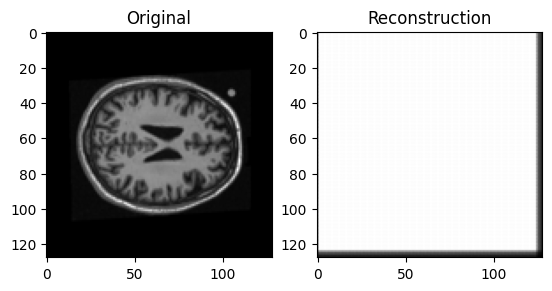

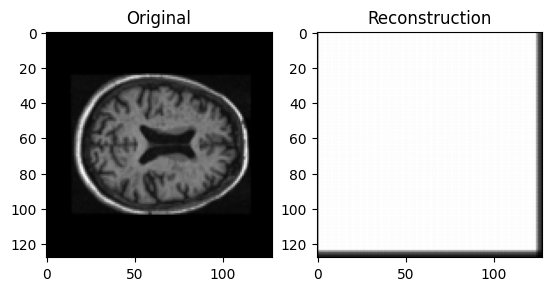

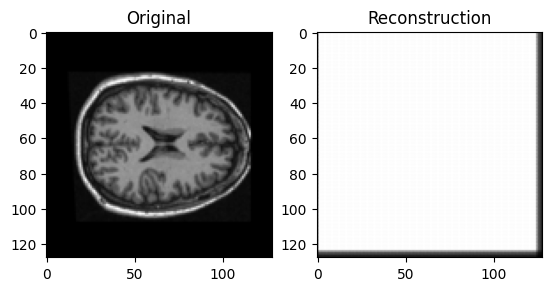

Epoch [1/10], Loss: 1.1163


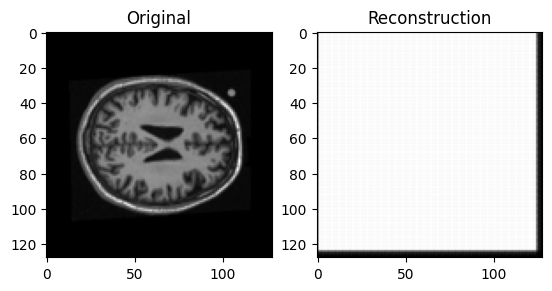

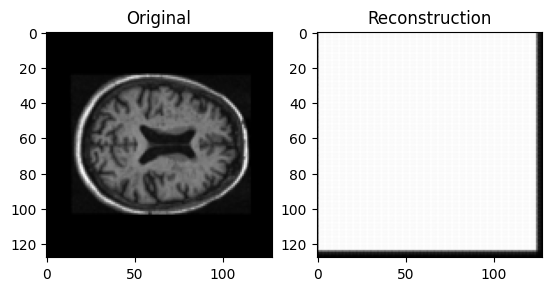

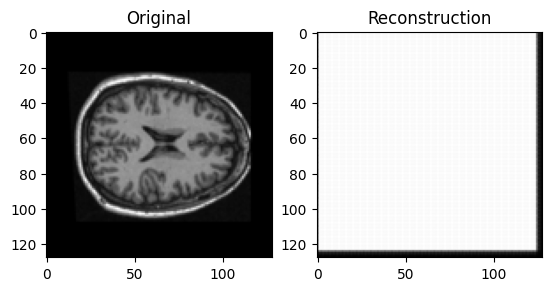

Epoch [2/10], Loss: 0.9803


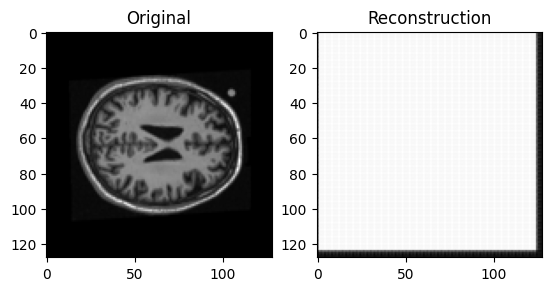

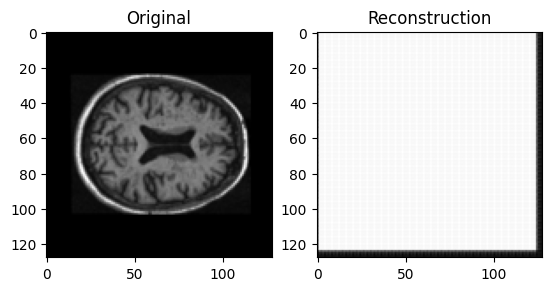

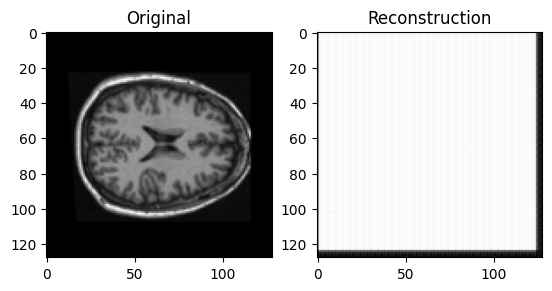

Epoch [3/10], Loss: 1.0225


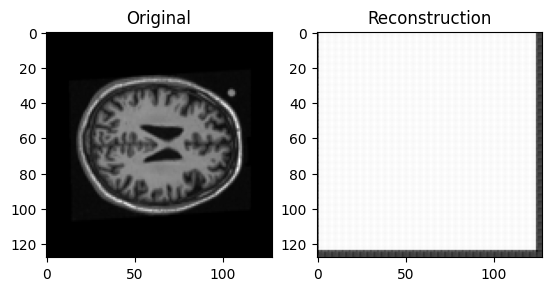

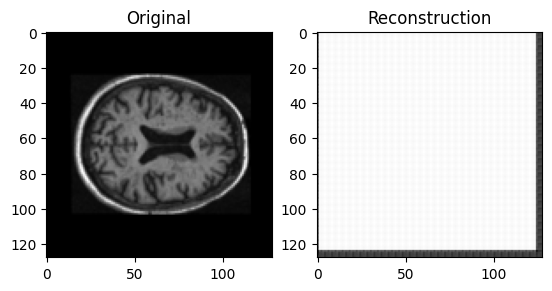

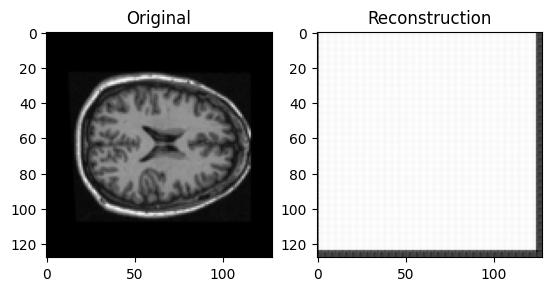

Epoch [4/10], Loss: 0.9513


KeyboardInterrupt: ignored

In [ ]:
def main():

    recon_losses = []
    vq_losses = []
    perplexities = []


    train_images, test_images, _ = get_image_slices()
    dataset = BrainSlicesDataset(train_images)
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

     # Some test samples for visualization
    test_samples_for_viz = torch.stack([test_images[i].unsqueeze(0) for i in range(3)]).to(device)

    # Initialize the VQ-VAE model
    vqvae_model = VQVAE(input_channels=1, hidden_channels=128, num_embeddings=512, embedding_dim=32).to(device)
    optimizer = torch.optim.Adam(vqvae_model.parameters(), lr=0.001)

     # Initialize and train VQVAE
    vqvae = VQVAETrainer(train_images.var(), 1, 128, 512, 32).to(device)
    print("Test samples for viz shape:", test_samples_for_viz.shape)
    train_vqvae(vqvae, train_loader, num_epochs=10, learning_rate=0.001, test_samples=test_samples_for_viz, recon_losses=recon_losses, vq_losses=vq_losses, perplexities=perplexities)

    # Initialize and train PixelCNN
    pixelcnn = PixelCNN((1, 128, 128), 256, 10)
    train_pixelcnn(pixelcnn, train_loader, num_epochs=10, learning_rate=0.001)

    # Visualization
    with torch.no_grad():
        # Get some test images for reconstruction visualization
        test_samples = torch.stack([test_images[i] for i in range(3)]).to(device)
        reconstructions, _, _ = vqvae(test_samples)

        # Visualize reconstructions
        visualize_reconstructions(test_samples, reconstructions)

        # Visualize PixelCNN's generation (multiple images)
        visualize_pixelcnn_generation_batch(pixelcnn, batch_size=5)

        # Compare original and PixelCNN generated
        for i in range(3):  # For 3 examples
            compare_original_and_generated(test_samples[i], pixelcnn)

if __name__ == "__main__":
    main()